# Guitar ETL and EDA

In [1]:
import os, io, requests, csv
# import json, re

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from scipy.stats import boxcox
from operator import itemgetter
from datetime import datetime

### Here's a Guitar (Axe) Class with *Lots* of Attributes (Features)

Some ducking was required to handle auctions missing certain details.

In [2]:
from Axe_Object import Axe

### Loop Through All Guitar JSON Data Files, Instantiate AXE Class Objects

In [3]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [7]:
axes = []
for filename in filenames:
    try:
        this_axe = Axe(filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price_usd > 101 and this_axe.price_usd < 1750:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            if this_axe.market != 'EBAY-US':
                continue
            if this_axe.year and this_axe.year > 2019:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [8]:
len(axes) # Our sample size.

12285

********

## EDA

**********

__Price Distribution:__

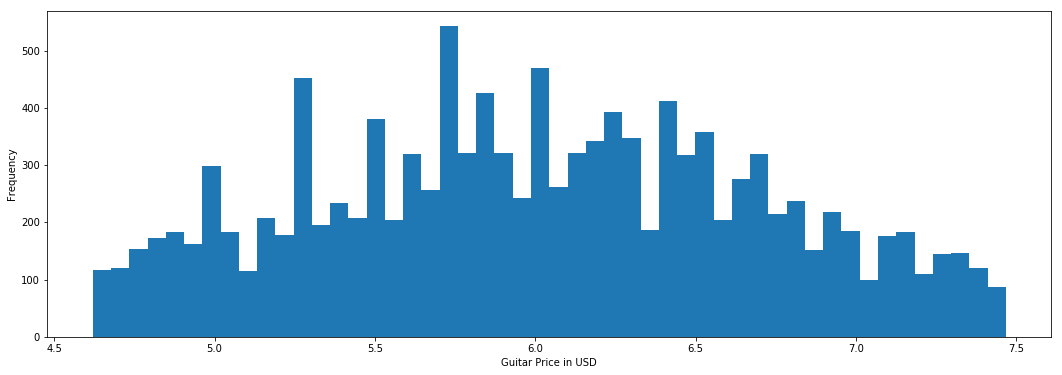

In [10]:
# prices = pd.Series([axe.price_usd for axe in axes])

prices = pd.Series(boxcox([axe.price_usd for axe in axes], lmbda=0), name = 'price')

plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

Some of the most expensive guitars:

In [11]:
spensive = [{'name':axe.title,
             'price': axe.price_usd,
            'year':axe.year} for axe in axes]
sorted(spensive, key=itemgetter('price'))[-5:]

[{'name': 'Gibson Custom Shop Historic Les Paul SG Standard VOS TV Yellow',
  'price': 1735.0,
  'year': None},
 {'name': 'MEGA RARE! Gibson Holy Explorer Electric Guitar in Case. 1 of 350 EVER made!',
  'price': 1735.0,
  'year': 2009},
 {'name': '1998 Fender Custom Shop American Classic Stratocaster Olympic White GORGEOUS!! ',
  'price': 1739.0,
  'year': 1998},
 {'name': 'Paul Reed Smith Singlecut Artist Stock / 20th Anniversary Edition ',
  'price': 1740.0,
  'year': 2006},
 {'name': '2015 Gibson Songwriter Deluxe EC Studio, Natural W/ Original Hard Case',
  'price': 1749.99,
  'year': 2015}]

**********

__Text Fields, for NLP:__

Listing Title:

In [12]:
[axe.title for axe in axes][:10] # All listings must have a title

['Fender Telecaster Vintage Electric Guitar MIM, 1994, Crimson Red',
 '2015 Gibson Les Paul LPM',
 'electric guitar and amp',
 "Squier II MIK Korea HSS '89 Stratocaster Electric Guitar w/ Maple Neck in Red ",
 'Ibanez Gio GRGBD120XL Left Handed Electric Guitar in Black Locking Tremelo',
 'Fender EVH Wolfgang Special Stealth WITH HARDSHELL CASE',
 "1960's Teisco Del Rey ET-200  MIJ Made in Japan Electric Guitar Sunburst ",
 'Jackson  Dinky JS  Gun Metal Gray',
 'Ibanez RG420EG SBK (Spiderweb Black) Guitar. Free Gig Bag & Free Shipping.',
 "HURRICANE BY MORRIS TELE MADE IN JAPAN IN 90'S TELE-GIB TYPE MOD EX. CONDITION"]

Mean Length of Title:

In [13]:
mean_title_len = sum(len(axe.title) for axe in axes)/len(axes)
print(f'{round(mean_title_len)} characters per title on average.')

58 characters per title on average.


In [14]:
print(f'{round(sum(1 for axe in axes if len(axe.title) < 46) / len(axes)*100,2)}% of listings have less than 46 characters in the title.')

25.88% of listings have less than 46 characters in the title.


Maybe "title has length less than 46 characters" should be a one-hot variable.

### Check for  "For parts" "as-is" etc

Listing __Sub__titles:

In [15]:
[axe.subtitle for axe in axes if axe.subtitle != None][-5:]

['offers considered',
 'Made in Mexico',
 'offers considered',
 'Great Value! Open box discount & free 2-year warranty!',
 'Great Value! Open box discount & free 2-year warranty!']

In [16]:
print(f'{round(((len([axe.subtitle for axe in axes if axe.subtitle != None]) / len(axes))*100),2)}% of listings include a subtitle.')

2.46% of listings include a subtitle.


Condition Descriptions:

In [17]:
[axe.condition_description for axe in axes if axe.condition_description != None][-5:]

['This Electric Guitar is in Excellent cosmetic condition. The headstock is free of nicks and dings. The tuning machines move and hold tune as intended. The neck is straight and free nicks with no signs of truss rod issues. The fingerboard is clean with little wear to the frets. The top has couple fine scratches which is typical from prior use and ownership but is free of dings to the edges. The knobs and toggle switch are moving smoothly and properly as intended. The back is free of buckle rash and scratches. Please see images.',
 'Crack in body on backside',
 'Used--History Unknown, Missing Hardware, Frame Only, Cosmetic Damage to Body',
 'Plays and sounds awesome!  Shows some signs of aging and wear with a few light dings and light scratches.  Case is rough but functional.  Please see all the photos.',
 "Plays and sounds awesome.  '80's shredder!! Shows some signs of use and wear with a few scratches and light dings, but nothing major. One of the six small floyd rose square blocks h

In [18]:
print(f'{round(((len([axe.condition_description for axe in axes if axe.condition_description != None]) / len(axes))*100),2)}% of listings include a condition description.')

32.33% of listings include a condition description.


Example of Description Full Text:

In [19]:
[axe.description for axe in axes][2000]

'This is a beautiful Candy Apple Red 1998 American Fender Stratocaster with David Gilmour EMG pickups. It also comes equipped with Fender locking Tuners. I cannot find any nicks or dings on the guitar, that being said it is used and is old enough to legally drink. A couple of things to note, the pickguard is a little cut up by the neck and the battery for the pickups is under the pickguard. \u2028 Please ask any questions. \u2028 Shipping to the contiguous 48 states only.'

In [20]:
print(f'{round(((len([axe.description for axe in axes if axe.description != None]) / len(axes))*100),2)}% of listings include a text description.')

99.28% of listings include a text description.


***********

__Number of Pics on eBay listing:__

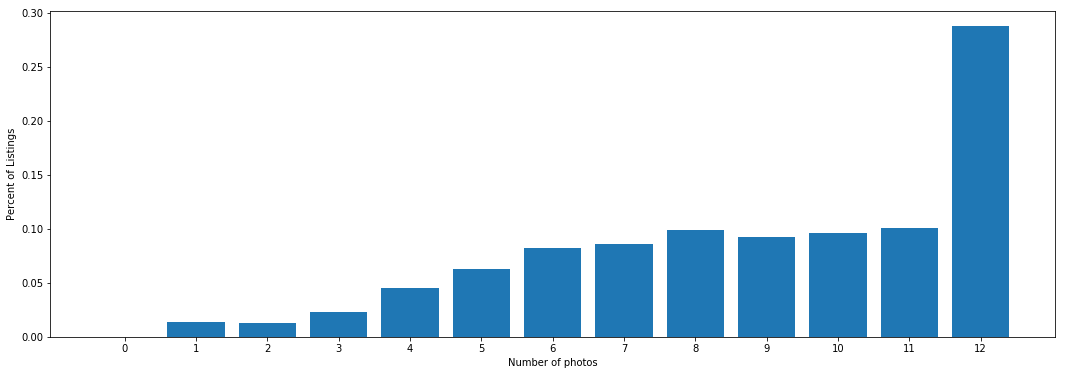

In [21]:
pic_quants = pd.Series([axe.pic_quantity for axe in axes]).value_counts()
plt.figure(figsize = (18,6))
plt.bar(pic_quants.index, pic_quants.values/len(axes))
plt.xticks(pic_quants.index)
plt.xlabel("Number of photos")
plt.ylabel("Percent of Listings")
plt.show()

In [22]:
for num_photos in range(13,0,-1):
    print(f'{round(len([axe.pic_quantity for axe in axes if axe.pic_quantity < num_photos]) / len(axes) * 100, 1)}% of auctions have less than {num_photos} photos.')

100.0% of auctions have less than 13 photos.
71.2% of auctions have less than 12 photos.
61.2% of auctions have less than 11 photos.
51.6% of auctions have less than 10 photos.
42.4% of auctions have less than 9 photos.
32.6% of auctions have less than 8 photos.
24.0% of auctions have less than 7 photos.
15.8% of auctions have less than 6 photos.
9.5% of auctions have less than 5 photos.
5.0% of auctions have less than 4 photos.
2.7% of auctions have less than 3 photos.
1.4% of auctions have less than 2 photos.
0.0% of auctions have less than 1 photos.


__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [23]:
[axe.pic for axe in axes][:5] # Just first five. You get it

['http://thumbs2.ebaystatic.com/m/mi0yHKrebkFb2j2Q2Hq94nQ/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mFax7qfKyVwHNv_LkUoh8uQ/140.jpg',
 'http://thumbs2.ebaystatic.com/m/mzH45-3u_IRtp5MUQlh8UYQ/140.jpg',
 'http://thumbs3.ebaystatic.com/m/mVs1Tgx0linaVjFviIxkUgw/140.jpg',
 'http://thumbs3.ebaystatic.com/m/maT-GoD60SDnPBWiBilfcSw/140.jpg']

**********

**Shipping Type:**

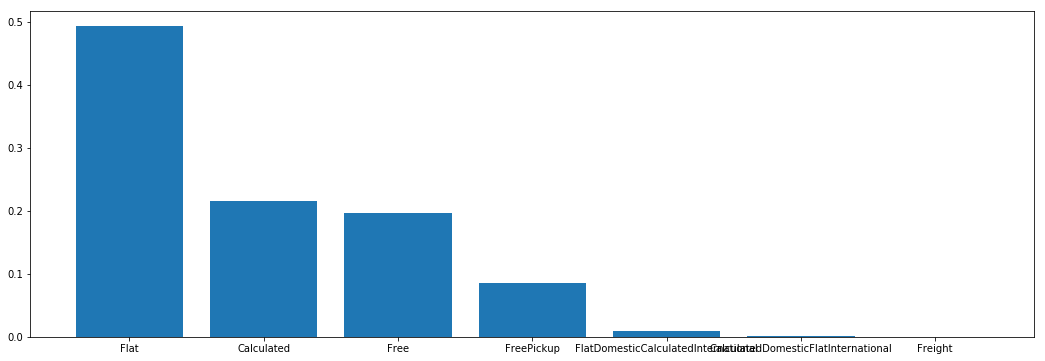

In [24]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([axe.ship_type for axe in axes]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(axes))
plt.show()

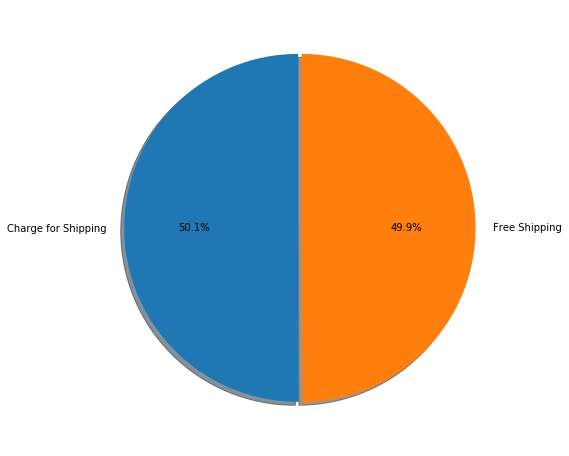

In [25]:
free = pd.Series([axe.price_shipping == 0 for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(free.values, explode=[.01,.01], labels=['Charge for Shipping', 'Free Shipping'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

In [26]:
print(f'${round(sum(axe.price_shipping for axe in axes if axe.price_shipping != 0) / len([axe.price_shipping for axe in axes if axe.price_shipping]),2)} - Average shipping cost (of those charging for shipping)')

$52.68 - Average shipping cost (of those charging for shipping)


**Offering Expedited Shipping:**

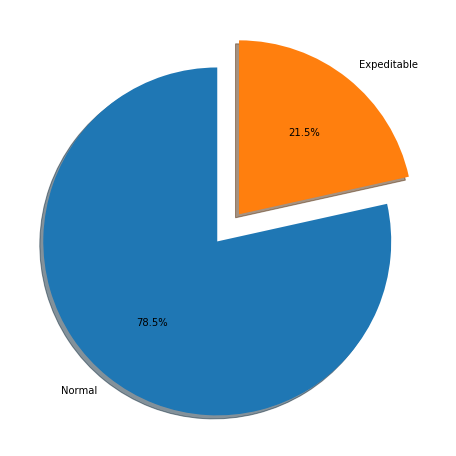

In [27]:
exp = pd.Series([axe.ship_expedite for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(exp.values, explode=[.1,.1], labels=['Normal', 'Expeditable'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__Listing Types:__

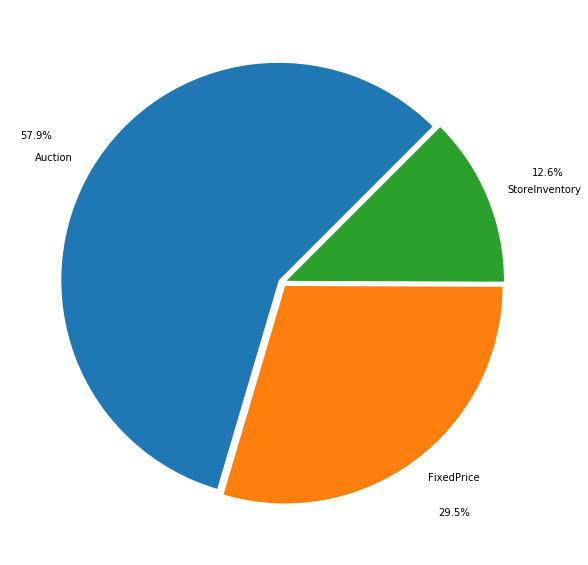

In [28]:
listing_types = pd.Series([axe.listing_type for axe in axes if axe.listing_type != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(listing_types.values, 
        labels = listing_types.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=45,
        explode = np.full(len(listing_types), .02))
plt.show()

****

__TEMPORAL STUFF__

**Handling Time in Days:**

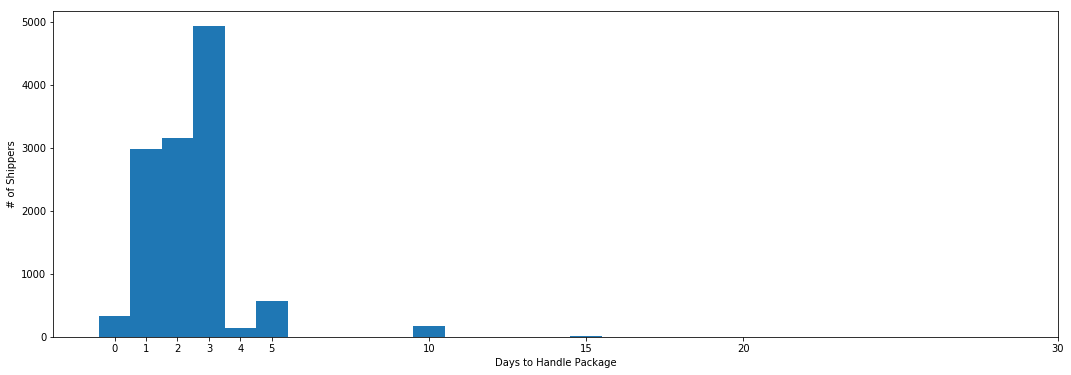

In [29]:
plt.figure(figsize = (18,6))
times = pd.Series([axe.ship_handling_time for axe in axes if axe.ship_handling_time != None])
plt.hist(times, bins=np.arange(max(times))-.5)
plt.xticks(sorted(times.value_counts().index))
plt.xlabel('Days to Handle Package')
plt.ylabel('# of Shippers')
plt.show()

__Duration of Auction in Days__:

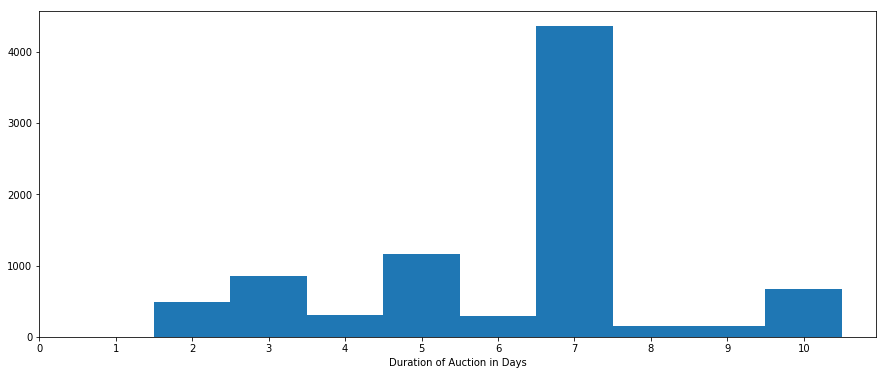

In [30]:
plt.figure(figsize = (15,6))
plt.hist([axe.duration/24 for axe in axes], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Duration of Auction in Days')
plt.show()

**Weekday of Auction Start:**

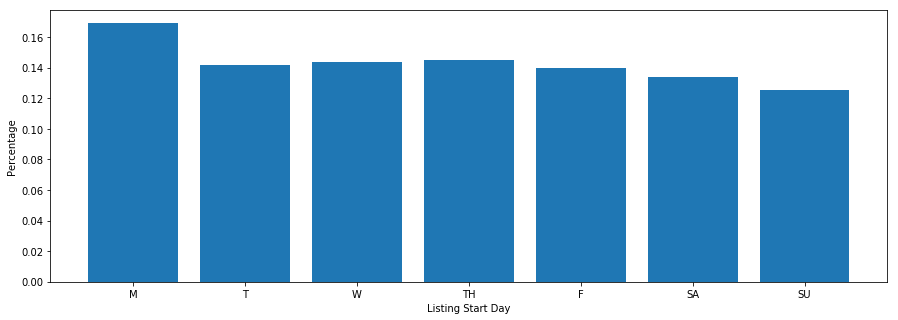

In [31]:
days = pd.Series([axe.start_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Weekday of Auction End:**

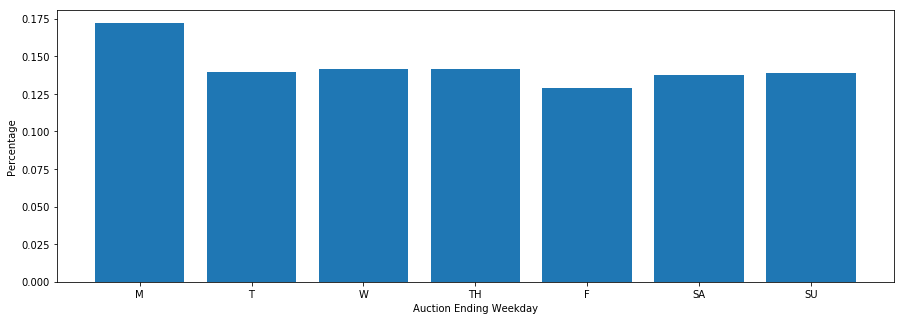

In [32]:
days = pd.Series([axe.end_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

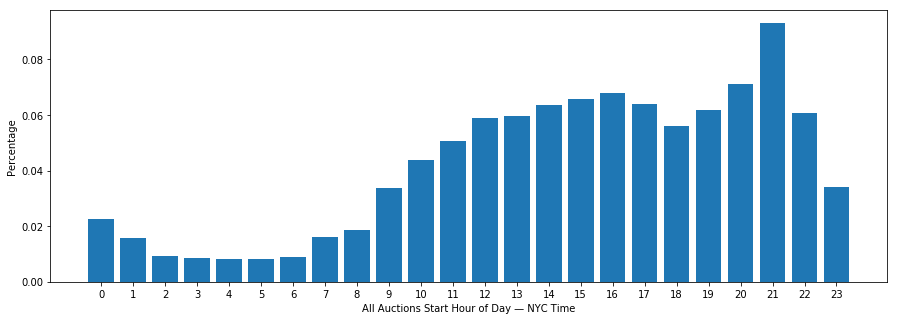

In [33]:
start_hours = pd.Series([axe.start_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((start_hours.index-5+24)%24, start_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions Start Hour of Day — NYC Time")
plt.show()

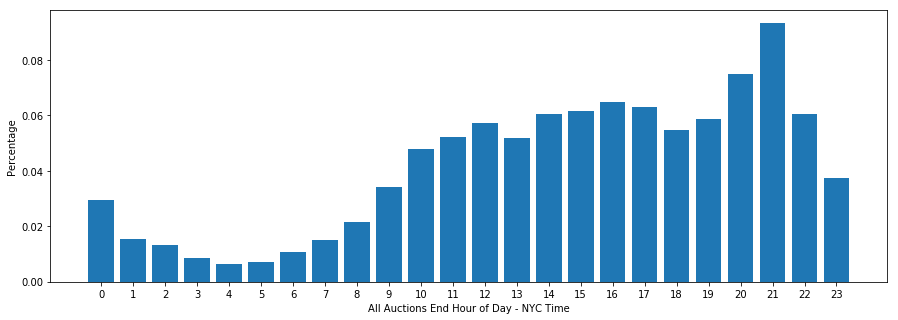

In [34]:
end_hours = pd.Series([axe.end_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((end_hours.index - 5 + 24)%24, end_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions End Hour of Day - NYC Time")
plt.show()

**Percentage of Auctions Offering Returns:**

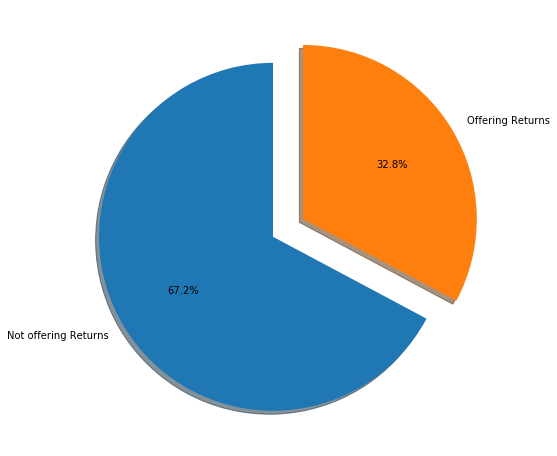

In [35]:
returns = pd.Series([axe.returns for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(returns.values, explode=[.1,.1], labels=['Not offering Returns', 'Offering Returns'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Return Time Window** (of those offering returns):

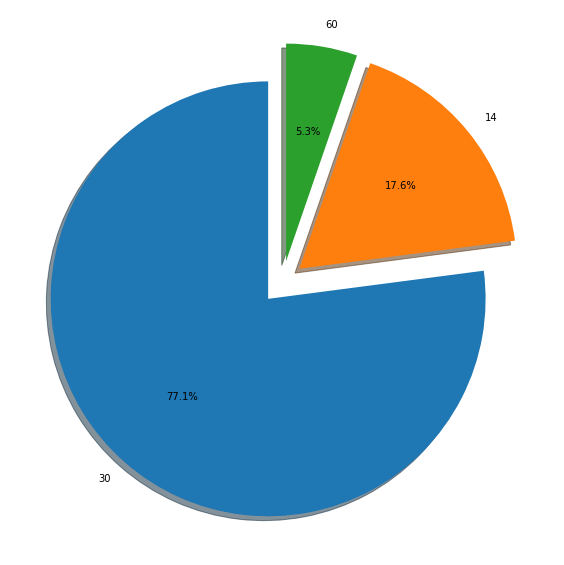

In [36]:
returns = pd.Series([axe.returns_time for axe in axes if axe.returns_time > 0]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(returns.values, explode=np.full(len(returns), .1), labels = returns.index, 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Offering AutoPay:**

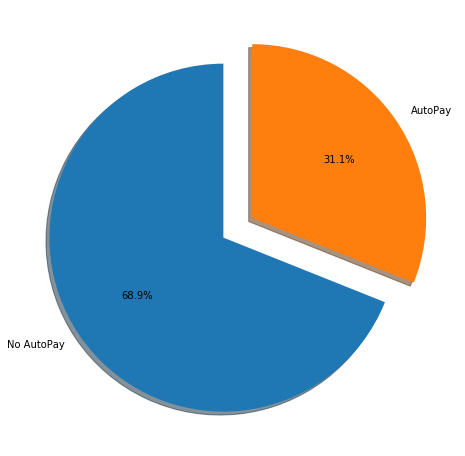

In [37]:
auto = pd.Series([axe.autopay for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(auto.values, explode=[.1,.1], 
        labels=['No AutoPay', 'AutoPay'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__"Best Offer":__

In [38]:
print(f'{round((sum(axe.best_offer_enabled for axe in axes) / len(axes)*100),2)}% of listings have "Best Offer" enabled.')

39.32% of listings have "Best Offer" enabled.


***

**Countries of Sellers:**

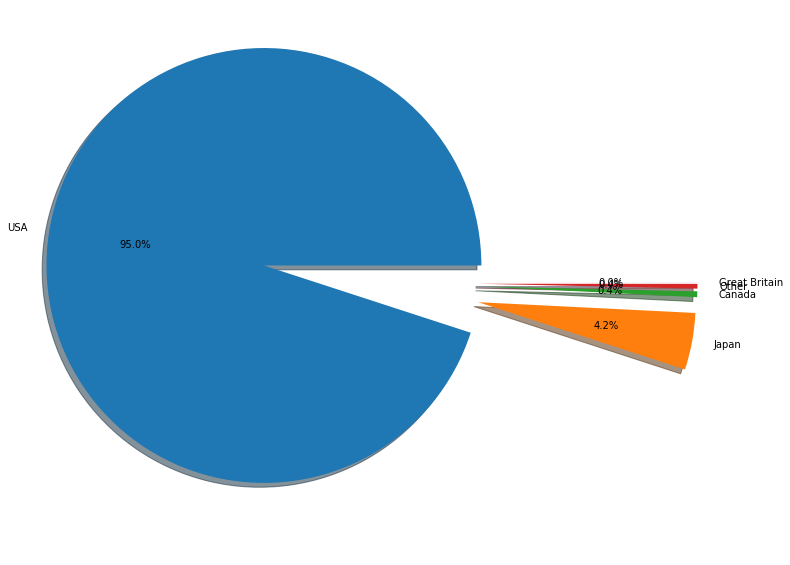

In [39]:
plt.figure(figsize = (10,10))
countries = pd.Series([axe.country_seller for axe in axes]).value_counts()
plt.pie(countries.values, labels=['USA', 'Japan', 'Canada', 
                                  'Other','Great Britain'], 
                            explode = np.full(len(countries), .5), 
        autopct='%1.1f%%',
       shadow = True)
plt.show()

__Seller Karma:__

Ebay Seller Feedback Score:

/anaconda3/envs/air/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/air/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


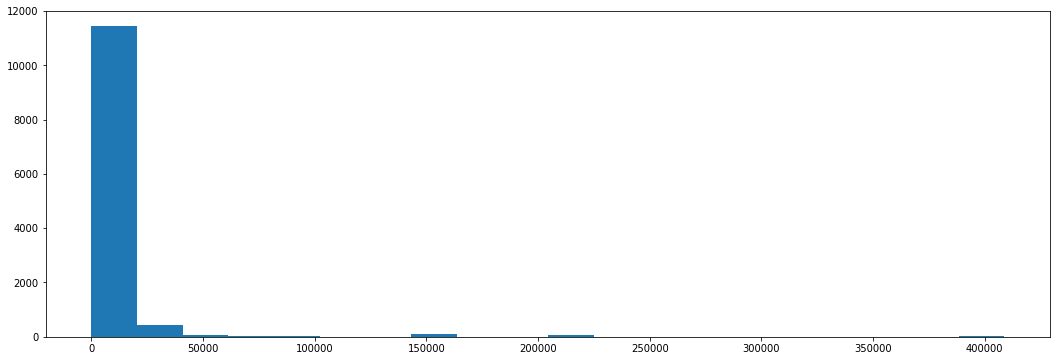

In [40]:
scores = pd.Series([axe.seller_feedback_score for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

In [41]:
scores.min(), scores.max()

(-2.0, 408817.0)

Pretty loooooong tail there. Let's chop it to see a little closer:

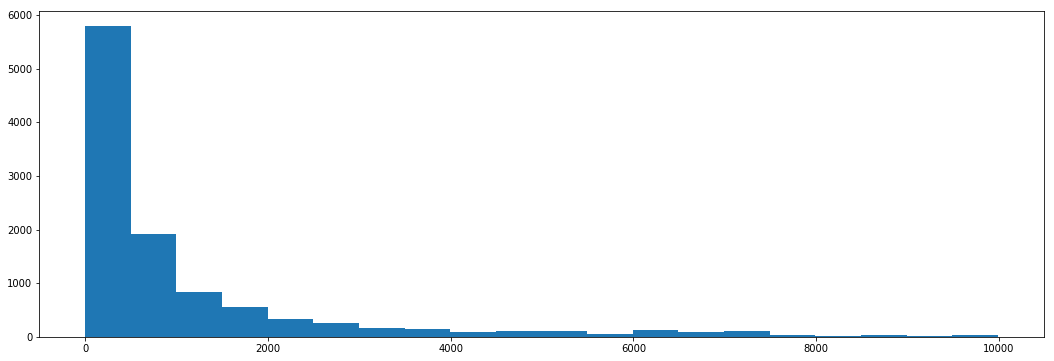

In [42]:
scores = pd.Series([axe.seller_feedback_score for axe in axes if axe.seller_feedback_score != None and axe.seller_feedback_score < 10000])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

eBay Positive Feedback Percentage:

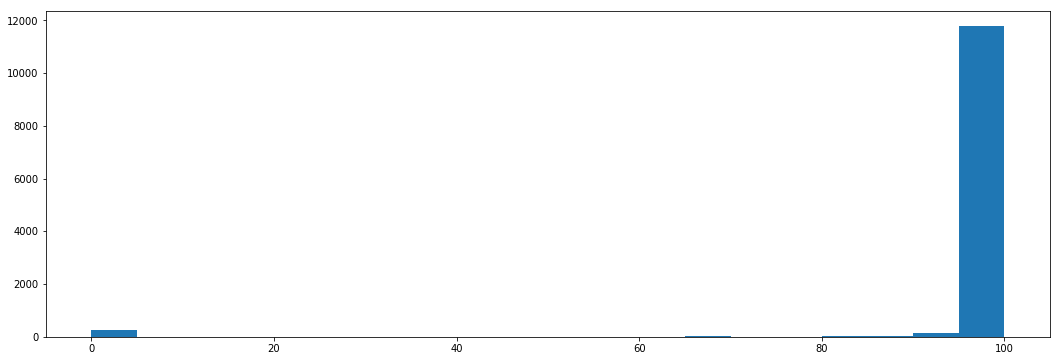

In [43]:
scores = pd.Series([axe.seller_positive_percent for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

***

__Guitars: Countries of Manufacture:__

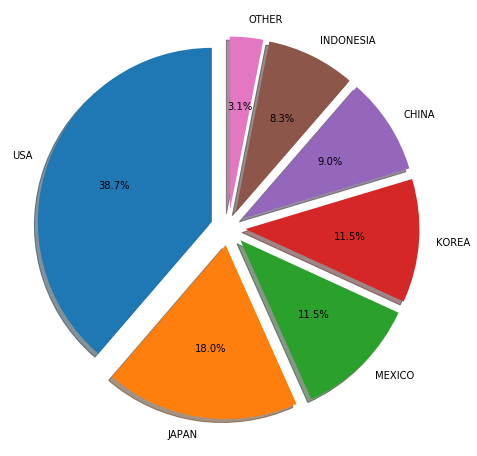

In [44]:
plt.figure(figsize = (8,8))
countries = pd.Series([axe.country_manufacture for axe in axes]).value_counts()
plt.pie(countries.values, labels= countries.index, explode = np.full(len(countries), .1), 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

***

__Guitar Body Colors:__

In [45]:
colors = pd.Series([axe.color for axe in axes if axe.color != None]).value_counts()
colores = list(colors.index)
colores[2] = 'ORANGE'
colores[3] = 'PINK'
colores[4] = 'BEIGE'
colores[5] = 'TAN'
# colores

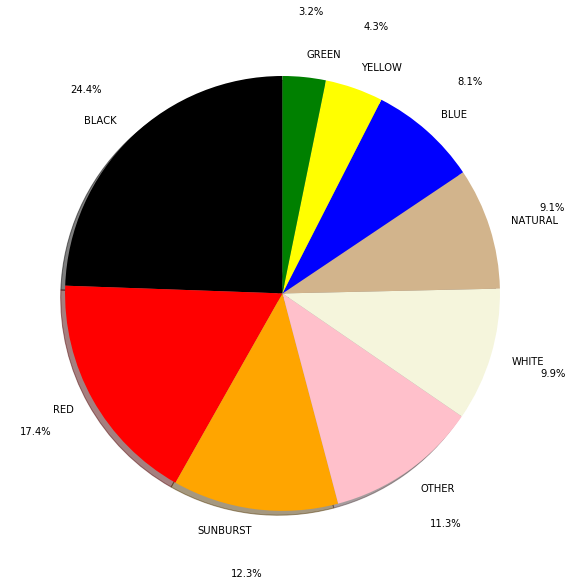

In [46]:
plt.figure(figsize = (10,10))
plt.pie(colors.values, labels=colors.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       shadow = True,
       startangle=90,
       colors = colores)
plt.show()

In [47]:
per = round((sum(pd.Series([axe.color for axe in axes if axe.color != None]).value_counts() / len(axes))*100),2)
print(f'{per}% of auctions list a body color where they\'re supposed to.')

57.0% of auctions list a body color where they're supposed to.


***

__Age of Guitars:__

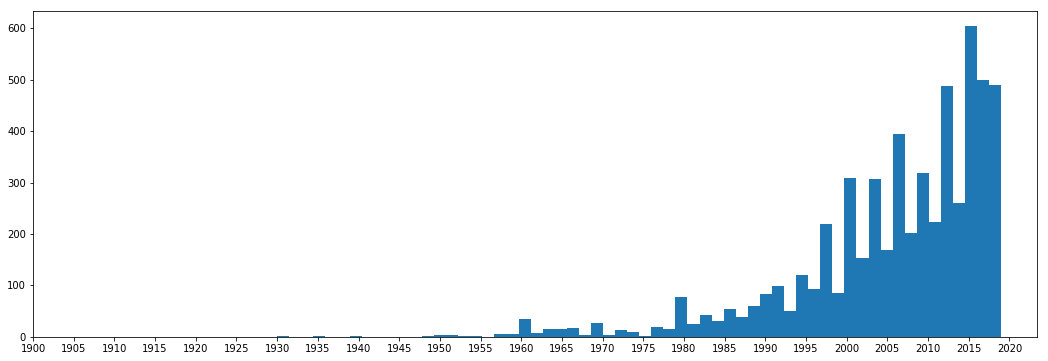

In [48]:
years = pd.Series([axe.year for axe in axes if axe.year != None])
plt.figure(figsize = (18,6))
plt.hist(years, bins=60)
plt.xticks(np.arange(1900,2021,5))
plt.show()

In [49]:
print(f'{round((len(years) / len(axes) * 100),2)}% of auctions have year values...might want to impute or something')

46.41% of auctions have year values...might want to impute or something


### What if we just bin years, drawing the line where it really matters?

***

__US Seller Locations, by Zip Code:__

In [ ]:
sales = [(axe.zip[0], axe.start_time) for axe in axes if axe.country_seller == 'US' and axe.zip != None]

In [ ]:
def get_usa_zips(url):
    usa_zips = {}
    census_zip_latlon = io.StringIO(requests.get(url).text)
    dialect = csv.Sniffer().sniff(census_zip_latlon.read(1024))
    census_zip_latlon.seek(0)
    reader = csv.reader(census_zip_latlon, dialect)
    for row in reader:
        usa_zips[row[0]] = (row[1], row[2])
    return usa_zips

In [ ]:
usa_zips = get_usa_zips(r'https://goo.gl/oYwpRM')

In [ ]:
sales = [sale for sale in sales if sale[1] > datetime.strptime('2018-08-01', '%Y-%m-%d')]

In [ ]:
def write_kepler_csv():
    with open('for_kepler.csv', mode='w') as sale_lat_long_datetime_file:

        sales_writer = csv.writer(sale_lat_long_datetime_file, delimiter=',', 
                                                           quotechar='"', 
                                                           quoting=csv.QUOTE_MINIMAL)

        ## The sample data set I got from the kepler github repo had rows named like so:
        sales_writer.writerow(['latitude','longitude','tpep_sale_datetime'])
        omissions = 0
        
        for sale in sales:
            try:
                datetime = sale[1]
                lat = usa_zips[sale[0]][0]
                lon = usa_zips[sale[0]][1]
                sales_writer.writerow([lat, lon,datetime])
            except KeyError:
                omissions += 1
        print (f"{round((omissions/len(sales))*100, 2)}% of zips were not found")

In [ ]:
write_kepler_csv()

***

__Guitar Brands__

In [ ]:
brand_counts = pd.Series([axe.brand for axe in axes]).value_counts()

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(brand_counts.values, 
        labels = brand_counts.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=90,
        explode = np.full(len(brand_counts), .1))
plt.show()

**Individual Guitar Models**

In [ ]:
model_counts = pd.Series([axe.model for axe in axes if axe.brand != None]).value_counts()

There is such a great variety of guitar models. Slivers of the pie smaller than "SQUIER" (rightmost tiny sliver) have been lumped into "OTHER".

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(model_counts.values, labels = model_counts.index,
                            explode = np.full(len(model_counts), .01))
plt.show()

***

__Right or Left Handed:__

In [ ]:
RL = pd.Series([axe.right_left_handed for axe in axes if axe.right_left_handed != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(RL.values, labels = RL.index,
                            explode = np.full(len(RL), .1))
plt.show()

***

__Body Types:__

In [ ]:
# pd.Series([(axe.title, axe.url) for axe in axes if axe.body_type == 'CLASSICAL']).value_counts()

In [ ]:
plt.figure(figsize=(10,10))
bodies = pd.Series([axe.body_type for axe in axes if axe.body_type != None]).value_counts()
plt.pie(bodies.values, 
        labels = bodies.index,
       explode = np.full(len(bodies), .1))
plt.show()

In [ ]:
print(f'{sum(bodies.values)} aka {round(sum(bodies.values) / len(axes) * 100, 2)}% of listings provide a body type.')

****

__Number of Strings:__

In [ ]:
strings = pd.Series([axe.string_config for axe in axes if axe.string_config != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(strings.values, 
        labels = strings.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=0,
        explode = np.full(len(strings), .8))
plt.show()

In [ ]:
print(f'{sum(strings.values)} aka {round(sum(strings.values) / len(axes) * 100, 2)}% of listings provide a string count.')